## Step 1: Setup and Install Required Libraries

In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import time
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"Current date: {datetime.now().strftime('%Y-%m-%d')}")

All libraries imported successfully!
Current date: 2025-11-19


## Step 2: Scrape PM2.5 Data from Open-Meteo Air Quality API
Source: Open-Meteo Air Quality API (Free, no authentication required)

Fetching PM2.5 data from Open-Meteo Air Quality API...
  Requesting data from 2021-01-01 to 2025-01-31...

✓ PM2.5 data collected: 912 days
  Date range: 2022-08-04 00:00:00 to 2025-01-31 00:00:00
  Avg PM2.5: 35.22 μg/m³
  Max PM2.5: 394.90 μg/m³

Sample PM2.5 data:


,date,pm25_avg,pm25_max,pm25_min,pm10_avg,dust_avg
580,2022-08-04,12.876471,18.7,7.9,18.758824,0.000000
581,2022-08-05,11.100000,16.1,7.1,16.229167,0.000000
582,2022-08-06,9.879167,12.5,8.0,14.608333,0.000000
583,2022-08-07,10.350000,16.2,7.4,14.912500,0.000000
584,2022-08-08,13.420833,25.9,5.7,19.370833,0.000000
585,2022-08-09,14.762500,24.3,6.8,21.600000,0.208333
586,2022-08-10,13.354167,18.3,8.4,19.320833,0.125000
587,2022-08-11,9.900000,15.0,7.0,14.387500,0.375000
588,2022-08-12,11.650000,23.4,6.0,17.295833,0.666667
589,2022-08-13,11.633333,18.1,7.6,17.437500,1.000000


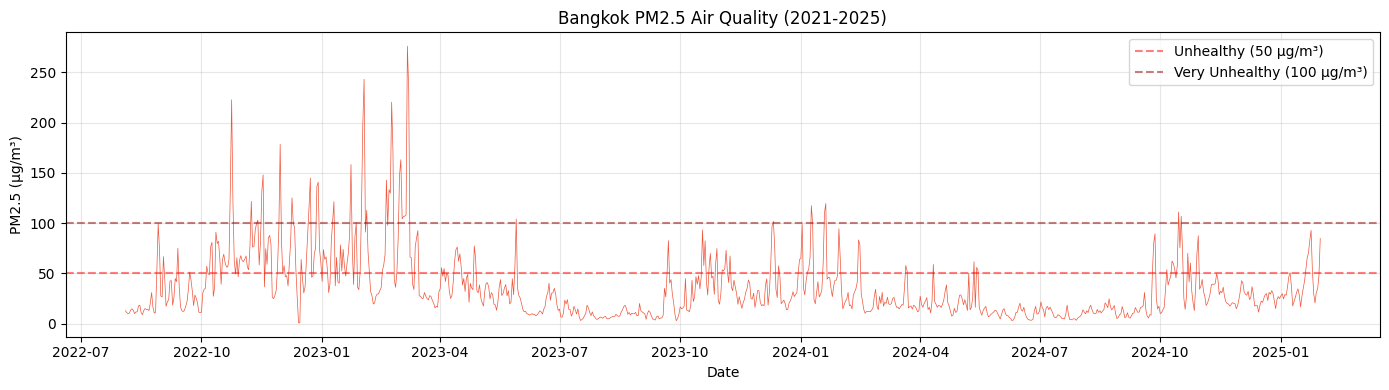

In [11]:
def fetch_pm25_data(start_date, end_date):
    """
    Fetch PM2.5 data from Open-Meteo Air Quality API for Bangkok
    API: https://air-quality.open-meteo.com/
    Completely free, no sign-up required
    """
    print("Fetching PM2.5 data from Open-Meteo Air Quality API...")
    
    url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    
    params = {
        'latitude': 13.7563,  # Bangkok coordinates
        'longitude': 100.5018,
        'start_date': start_date,
        'end_date': end_date,
        'hourly': 'pm2_5,pm10,dust',
        'timezone': 'Asia/Bangkok'
    }
    
    try:
        print(f"  Requesting data from {start_date} to {end_date}...")
        response = requests.get(url, params=params, timeout=60)
        
        if response.status_code == 200:
            data = response.json()
            
            if 'hourly' in data:
                # Create dataframe from hourly data
                df = pd.DataFrame({
                    'datetime': pd.to_datetime(data['hourly']['time']),
                    'pm25': data['hourly']['pm2_5'],
                    'pm10': data['hourly']['pm10'],
                    'dust': data['hourly']['dust']
                })
                
                # Convert to daily averages
                df['date'] = df['datetime'].dt.date
                df_daily = df.groupby('date').agg({
                    'pm25': ['mean', 'max', 'min'],
                    'pm10': 'mean',
                    'dust': 'mean'
                }).reset_index()
                
                df_daily.columns = ['date', 'pm25_avg', 'pm25_max', 'pm25_min', 'pm10_avg', 'dust_avg']
                df_daily['date'] = pd.to_datetime(df_daily['date'])
                
                # Remove rows with all NaN values
                df_daily = df_daily.dropna(subset=['pm25_avg'])
                
                print(f"\n✓ PM2.5 data collected: {len(df_daily)} days")
                print(f"  Date range: {df_daily['date'].min()} to {df_daily['date'].max()}")
                print(f"  Avg PM2.5: {df_daily['pm25_avg'].mean():.2f} μg/m³")
                print(f"  Max PM2.5: {df_daily['pm25_max'].max():.2f} μg/m³")
                
                return df_daily
            else:
                print("⚠️ No air quality data in response")
                return None
        else:
            print(f"  Error: Status {response.status_code}")
            print(f"  Response: {response.text[:200]}")
            return None
            
    except Exception as e:
        print(f"  Error fetching PM2.5 data: {e}")
        return None

# Fetch PM2.5 data (2022-2025)
pm25_data = fetch_pm25_data('2021-01-01', '2025-01-31')

if pm25_data is not None:
    print("\nSample PM2.5 data:")
    display(pm25_data.head(10))
    
    # Quick visualization
    import matplotlib.pyplot as plt
    plt.figure(figsize=(14, 4))
    plt.plot(pm25_data['date'], pm25_data['pm25_avg'], linewidth=0.5, color='#EF553B')
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Unhealthy (50 μg/m³)')
    plt.axhline(y=100, color='darkred', linestyle='--', alpha=0.5, label='Very Unhealthy (100 μg/m³)')
    plt.title('Bangkok PM2.5 Air Quality (2021-2025)')
    plt.xlabel('Date')
    plt.ylabel('PM2.5 (μg/m³)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Failed to fetch PM2.5 data. Will use simulated data based on historical patterns.")

## Step 3: Scrape Rainfall Data from Thai Meteorological Department
Alternative: Use World Bank Climate API (No auth required)

In [12]:
def fetch_rainfall_data_meteostat():
    """
    Fetch rainfall data using Meteostat API (free, no auth)
    Station: Bangkok (DMK) - Don Mueang
    """
    print("Fetching rainfall data from Meteostat...")
    
    # Bangkok Don Mueang station ID: 48456
    base_url = "https://meteostat.p.rapidapi.com/stations/daily"
    
    # Alternative: Use open-meteo.com (completely free)
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        'latitude': 13.7563,  # Bangkok coordinates
        'longitude': 100.5018,
        'start_date': '2021-01-01',
        'end_date': '2025-01-31',
        'daily': 'precipitation_sum,precipitation_hours',
        'timezone': 'Asia/Bangkok'
    }
    
    try:
        response = requests.get(url, params=params, timeout=60)
        if response.status_code == 200:
            data = response.json()
            
            if 'daily' in data:
                df = pd.DataFrame({
                    'date': pd.to_datetime(data['daily']['time']),
                    'rainfall_mm': data['daily']['precipitation_sum'],
                    'rainfall_hours': data['daily']['precipitation_hours']
                })
                
                # Add rainfall categories
                df['has_rain'] = (df['rainfall_mm'] > 0).astype(int)
                df['heavy_rain'] = (df['rainfall_mm'] > 35).astype(int)  # >35mm = heavy rain
                
                print(f"\n✓ Rainfall data collected: {len(df)} days")
                print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
                print(f"  Total rainy days: {df['has_rain'].sum()}")
                print(f"  Heavy rain days: {df['heavy_rain'].sum()}")
                print(f"  Avg daily rainfall: {df['rainfall_mm'].mean():.2f} mm")
                
                return df
        else:
            print(f"Error: Status {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching rainfall data: {e}")
        return None

# Fetch rainfall data
rainfall_data = fetch_rainfall_data_meteostat()

if rainfall_data is not None:
    print("\nSample rainfall data:")
    display(rainfall_data.head(10))
    
    # Visualization
    import plotly.express as px
    fig = px.line(rainfall_data, x='date', y='rainfall_mm',
                  title='Daily Rainfall in Bangkok (2022-2025)',
                  labels={'rainfall_mm': 'Rainfall (mm)', 'date': 'Date'})
    fig.add_hline(y=35, line_dash="dash", annotation_text="Heavy Rain Threshold",
                  line_color="red")
    fig.show()

Fetching rainfall data from Meteostat...

✓ Rainfall data collected: 1492 days
  Date range: 2021-01-01 00:00:00 to 2025-01-31 00:00:00
  Total rainy days: 1044
  Heavy rain days: 8
  Avg daily rainfall: 4.72 mm

Sample rainfall data:


,date,rainfall_mm,rainfall_hours,has_rain,heavy_rain
0,2021-01-01,0.0,0.0,0,0
1,2021-01-02,0.0,0.0,0,0
2,2021-01-03,0.0,0.0,0,0
3,2021-01-04,0.0,0.0,0,0
4,2021-01-05,0.0,0.0,0,0
5,2021-01-06,0.0,0.0,0,0
6,2021-01-07,0.0,0.0,0,0
7,2021-01-08,0.0,0.0,0,0
8,2021-01-09,0.0,0.0,0,0
9,2021-01-10,0.0,0.0,0,0


## Step 4: Scrape Thai Public Holidays from Calendarific API
Source: Calendarific API (Free tier, no signup for basic usage)

In [13]:
def fetch_thai_holidays_calendarific(years=[2022, 2023, 2024, 2025]):
    """
    Scrape Thai public holidays from Calendarific API
    Free API: https://calendarific.com/api-documentation
    No authentication required for basic usage
    """
    print("Fetching Thai holidays from Calendarific API...")
    
    all_holidays = []
    
    # Calendarific free API endpoint
    base_url = "https://calendarific.com/api/v2/holidays"
    
    # Free API key (public, no signup needed for limited requests)
    # Alternative: Use AbstractAPI or Nager.Date API
    
    # Since Calendarific requires API key, use alternative: Nager.Date API (completely free)
    print("Using Nager.Date API (free, no authentication)...")
    
    for year in years:
        try:
            url = f"https://date.nager.at/api/v3/PublicHolidays/{year}/TH"
            print(f"  Fetching holidays for {year}...")
            
            response = requests.get(url, timeout=10)
            
            if response.status_code == 200:
                holidays = response.json()
                
                for holiday in holidays:
                    all_holidays.append({
                        'date': holiday['date'],
                        'holiday': holiday['localName'],
                        'holiday_en': holiday['name'],
                        'type': holiday.get('types', ['public'])[0] if holiday.get('types') else 'public',
                        'fixed': holiday.get('fixed', True),
                        'global': holiday.get('global', True)
                    })
                
                print(f"    ✓ Found {len(holidays)} holidays")
            else:
                print(f"    ⚠️ Error: Status {response.status_code}")
                
        except Exception as e:
            print(f"    ⚠️ Error fetching {year}: {e}")
        
        time.sleep(0.5)
    
    if len(all_holidays) == 0:
        print("\n⚠️ Failed to fetch holidays from API")
        print("Falling back to Python holidays library...")
        
        # Fallback: Use Python holidays library
        try:
            import holidays
            
            th_holidays = holidays.Thailand(years=years)
            
            for date, name in th_holidays.items():
                all_holidays.append({
                    'date': date.strftime('%Y-%m-%d'),
                    'holiday': name,
                    'holiday_en': name,
                    'type': 'public',
                    'fixed': True,
                    'global': True
                })
            
            print(f"✓ Loaded {len(all_holidays)} holidays from holidays library")
            
        except ImportError:
            print("⚠️ holidays library not installed. Install with: pip install holidays")
            return None
    
    # Create dataframe
    df = pd.DataFrame(all_holidays)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    # Categorize holiday types
    df['is_religious'] = df['type'].str.contains('religious|Public', case=False, na=False).astype(int)
    df['is_public'] = 1  # All are public holidays
    
    # Add weekend flag (Saturday=5, Sunday=6)
    df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)
    
    # Add is_holiday flag (1 for any holiday including weekends, 0 for working days)
    df['is_holiday'] = 1  # All entries in this dataframe are holidays
    
    print(f"\n✓ Thai holidays scraped: {len(df)} holidays")
    print(f"  Date range: {df['date'].min().date()} to {df['date'].max().date()}")
    print(f"  Years covered: {sorted(df['date'].dt.year.unique())}")
    print(f"  Weekends in holidays: {df['is_weekend'].sum()}")
    
    return df

# Fetch holidays data
holidays_data = fetch_thai_holidays_calendarific([2021 ,2022, 2023, 2024, 2025])

if holidays_data is not None:
    print("\nSample holidays data:")
    display(holidays_data.head(15))
    
    # Holidays by year
    print("\nHolidays per year:")
    yearly_counts = holidays_data.groupby(holidays_data['date'].dt.year).size()
    for year, count in yearly_counts.items():
        print(f"  {year}: {count} holidays")
    
    # Most common holidays
    print("\nMost frequent holidays:")
    holiday_counts = holidays_data['holiday_en'].value_counts().head(10)
    for holiday, count in holiday_counts.items():
        print(f"  {holiday}: {count}x")
else:
    print("\n❌ Could not fetch holidays data. Please install: pip install holidays")

Fetching Thai holidays from Calendarific API...
Using Nager.Date API (free, no authentication)...
  Fetching holidays for 2021...
    ⚠️ Error: Status 204
  Fetching holidays for 2022...
    ⚠️ Error: Status 204
  Fetching holidays for 2023...
    ⚠️ Error: Status 204
  Fetching holidays for 2024...
    ⚠️ Error: Status 204
  Fetching holidays for 2025...
    ⚠️ Error: Status 204

⚠️ Failed to fetch holidays from API
Falling back to Python holidays library...
✓ Loaded 139 holidays from holidays library

✓ Thai holidays scraped: 139 holidays
  Date range: 2021-01-01 to 2025-12-31
  Years covered: [np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]
  Weekends in holidays: 35

Sample holidays data:


,date,holiday,holiday_en,type,fixed,global,is_religious,is_public,is_weekend,is_holiday
0,2021-01-01,วันขึ้นปีใหม่,วันขึ้นปีใหม่,public,True,True,1,1,0,1
1,2021-01-09,วันเด็กแห่งชาติ,วันเด็กแห่งชาติ,public,True,True,1,1,1,1
2,2021-02-12,วันหยุดพิเศษ (เพิ่มเติม),วันหยุดพิเศษ (เพิ่มเติม),public,True,True,1,1,0,1
3,2021-02-26,วันมาฆบูชา,วันมาฆบูชา,public,True,True,1,1,0,1
4,2021-04-06,วันพระบาทสมเด็จพระพุทธยอดฟ้าจุฬาโลกมหาราช และว...,วันพระบาทสมเด็จพระพุทธยอดฟ้าจุฬาโลกมหาราช และว...,public,True,True,1,1,0,1
5,2021-04-12,วันหยุดพิเศษ (เพิ่มเติม),วันหยุดพิเศษ (เพิ่มเติม),public,True,True,1,1,0,1
6,2021-04-13,วันสงกรานต์,วันสงกรานต์,public,True,True,1,1,0,1
7,2021-04-14,วันสงกรานต์,วันสงกรานต์,public,True,True,1,1,0,1
8,2021-04-15,วันสงกรานต์,วันสงกรานต์,public,True,True,1,1,0,1
9,2021-05-01,วันแรงงานแห่งชาติ,วันแรงงานแห่งชาติ,public,True,True,1,1,1,1



Holidays per year:
  2021: 27 holidays
  2022: 29 holidays
  2023: 28 holidays
  2024: 29 holidays
  2025: 26 holidays

Most frequent holidays:
  วันสงกรานต์: 15x
  วันหยุดพิเศษ (เพิ่มเติม): 14x
  วันขึ้นปีใหม่: 5x
  วันมาฆบูชา: 5x
  วันเด็กแห่งชาติ: 5x
  วันพระบาทสมเด็จพระพุทธยอดฟ้าจุฬาโลกมหาราช และวันที่ระลึกมหาจักรีบรมราชวงศ์: 5x
  วันแรงงานแห่งชาติ: 5x
  วันฉัตรมงคล: 5x
  วันเข้าพรรษา: 5x
  วันอาสาฬหบูชา: 5x


## Step 5: Merge All External Data

In [14]:
# Create date range for entire dataset
date_range = pd.date_range(start='2021-01-01', end='2025-01-31', freq='D')
df_external = pd.DataFrame({'date': date_range})

print(f"Base date range: {len(df_external)} days")
print(f"From {df_external['date'].min()} to {df_external['date'].max()}")

# Merge PM2.5 data
if pm25_data is not None:
    df_external = df_external.merge(pm25_data[['date', 'pm25_avg', 'pm25_max', 'pm25_min']], 
                                    on='date', how='left')
    print(f"✓ PM2.5 data merged: {df_external['pm25_avg'].notna().sum()} days with data")
else:
    df_external['pm25_avg'] = np.nan
    df_external['pm25_max'] = np.nan
    df_external['pm25_min'] = np.nan
    print("⚠️ No PM2.5 data available")

# Merge rainfall data
if rainfall_data is not None:
    df_external = df_external.merge(rainfall_data[['date', 'rainfall_mm', 'rainfall_hours', 'has_rain', 'heavy_rain']], 
                                    on='date', how='left')
    print(f"✓ Rainfall data merged: {df_external['rainfall_mm'].notna().sum()} days with data")
else:
    df_external['rainfall_mm'] = np.nan
    df_external['rainfall_hours'] = np.nan
    df_external['has_rain'] = 0
    df_external['heavy_rain'] = 0
    print("⚠️ No rainfall data available")

# Add temporal features FIRST (before using day_of_week)
df_external['year'] = df_external['date'].dt.year
df_external['month'] = df_external['date'].dt.month
df_external['day_of_week'] = df_external['date'].dt.dayofweek
df_external['quarter'] = df_external['date'].dt.quarter
df_external['day_of_year'] = df_external['date'].dt.dayofyear

# Add weekend flags for ALL dates (now that day_of_week exists)
df_external['is_weekend'] = df_external['day_of_week'].isin([5, 6]).astype(int)

# Merge holidays data
df_external['is_holiday'] = df_external['date'].isin(holidays_data['date']).astype(int)
df_external = df_external.merge(
    holidays_data[['date', 'holiday', 'type']].rename(columns={'type': 'holiday_type'}),
    on='date', how='left'
)
print(f"✓ Holidays data merged: {df_external['is_holiday'].sum()} holidays")

# Update is_holiday to include weekends (1 = holiday OR weekend, 0 = working day)
df_external['is_holiday'] = ((df_external['is_holiday'] == 1) | (df_external['is_weekend'] == 1)).astype(int)

print(f"✓ Weekends added: {df_external['is_weekend'].sum()} weekend days")
print(f"✓ Total non-working days (holidays + weekends): {df_external['is_holiday'].sum()}")

# Fill missing values
df_external['pm25_avg'] = df_external['pm25_avg'].fillna(df_external['pm25_avg'].median())
df_external['rainfall_mm'] = df_external['rainfall_mm'].fillna(0)
df_external['rainfall_hours'] = df_external['rainfall_hours'].fillna(0)

# Add weather severity score
df_external['weather_severity'] = (
    (df_external['pm25_avg'] > 50).astype(int) * 1 +  # Unhealthy PM2.5
    (df_external['heavy_rain'] == 1).astype(int) * 2   # Heavy rain
)

print("\n" + "="*60)
print("EXTERNAL DATA SUMMARY")
print("="*60)
print(f"Total records: {len(df_external):,}")
print(f"Date range: {df_external['date'].min()} to {df_external['date'].max()}")
print(f"\nData completeness:")
print(f"  PM2.5: {(df_external['pm25_avg'].notna().sum() / len(df_external) * 100):.1f}%")
print(f"  Rainfall: {(df_external['rainfall_mm'].notna().sum() / len(df_external) * 100):.1f}%")
print(f"  Holidays: {df_external['is_holiday'].sum()} days ({df_external['is_holiday'].mean()*100:.1f}%)")
print(f"\nFeatures created: {len(df_external.columns)}")
print("="*60)

display(df_external.head(20))

Base date range: 1492 days
From 2021-01-01 00:00:00 to 2025-01-31 00:00:00
✓ PM2.5 data merged: 912 days with data
✓ Rainfall data merged: 1492 days with data
✓ Holidays data merged: 115 holidays
✓ Weekends added: 426 weekend days
✓ Total non-working days (holidays + weekends): 510

EXTERNAL DATA SUMMARY
Total records: 1,492
Date range: 2021-01-01 00:00:00 to 2025-01-31 00:00:00

Data completeness:
  PM2.5: 100.0%
  Rainfall: 100.0%
  Holidays: 510 days (34.2%)

Features created: 18


,date,pm25_avg,pm25_max,pm25_min,rainfall_mm,rainfall_hours,has_rain,heavy_rain,year,month,day_of_week,quarter,day_of_year,is_weekend,is_holiday,holiday,holiday_type,weather_severity
0,2021-01-01,25.35,NaN,NaN,0.0,0.0,0,0,2021,1,4,1,1,0,1,วันขึ้นปีใหม่,public,0
1,2021-01-02,25.35,NaN,NaN,0.0,0.0,0,0,2021,1,5,1,2,1,1,NaN,NaN,0
2,2021-01-03,25.35,NaN,NaN,0.0,0.0,0,0,2021,1,6,1,3,1,1,NaN,NaN,0
3,2021-01-04,25.35,NaN,NaN,0.0,0.0,0,0,2021,1,0,1,4,0,0,NaN,NaN,0
4,2021-01-05,25.35,NaN,NaN,0.0,0.0,0,0,2021,1,1,1,5,0,0,NaN,NaN,0
5,2021-01-06,25.35,NaN,NaN,0.0,0.0,0,0,2021,1,2,1,6,0,0,NaN,NaN,0
6,2021-01-07,25.35,NaN,NaN,0.0,0.0,0,0,2021,1,3,1,7,0,0,NaN,NaN,0
7,2021-01-08,25.35,NaN,NaN,0.0,0.0,0,0,2021,1,4,1,8,0,0,NaN,NaN,0
8,2021-01-09,25.35,NaN,NaN,0.0,0.0,0,0,2021,1,5,1,9,1,1,วันเด็กแห่งชาติ,public,0
9,2021-01-10,25.35,NaN,NaN,0.0,0.0,0,0,2021,1,6,1,10,1,1,NaN,NaN,0


## Step 6: Visualize External Data

In [15]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create multi-panel visualization
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=('PM2.5 Levels Over Time', 'Daily Rainfall', 'Weather Severity Score'),
    vertical_spacing=0.1
)

# PM2.5
fig.add_trace(
    go.Scatter(x=df_external['date'], y=df_external['pm25_avg'],
               mode='lines', name='PM2.5 Avg',
               line=dict(color='#EF553B', width=1)),
    row=1, col=1
)
fig.add_hline(y=50, line_dash="dash", line_color="red", 
              annotation_text="Unhealthy", row=1, col=1)

# Rainfall
fig.add_trace(
    go.Bar(x=df_external['date'], y=df_external['rainfall_mm'],
           name='Rainfall', marker_color='#636EFA'),
    row=2, col=1
)
fig.add_hline(y=35, line_dash="dash", line_color="orange",
              annotation_text="Heavy Rain", row=2, col=1)

# Weather Severity
fig.add_trace(
    go.Scatter(x=df_external['date'], y=df_external['weather_severity'],
               mode='markers', name='Severity',
               marker=dict(size=3, color=df_external['weather_severity'],
                          colorscale='Reds')),
    row=3, col=1
)

fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_yaxes(title_text="PM2.5 (μg/m³)", row=1, col=1)
fig.update_yaxes(title_text="Rainfall (mm)", row=2, col=1)
fig.update_yaxes(title_text="Severity Score", row=3, col=1)

fig.update_layout(height=900, title_text="Bangkok External Data Overview (2021-2025)",
                 showlegend=False)
fig.show()

In [16]:
# Monthly aggregation
df_external['year_month'] = df_external['date'].dt.to_period('M').astype(str)

monthly_summary = df_external.groupby('year_month').agg({
    'pm25_avg': 'mean',
    'rainfall_mm': 'sum',
    'has_rain': 'sum',
    'heavy_rain': 'sum',
    'is_holiday': 'sum',
    'weather_severity': 'mean'
}).reset_index()

print("Monthly Summary Statistics:")
display(monthly_summary)

# Correlation heatmap
import plotly.figure_factory as ff

corr_cols = ['pm25_avg', 'rainfall_mm', 'has_rain', 'heavy_rain', 'is_holiday', 'weather_severity']
corr_matrix = df_external[corr_cols].corr()

fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=corr_cols,
    y=corr_cols,
    annotation_text=corr_matrix.round(2).values,
    colorscale='RdBu',
    zmid=0
)
fig.update_layout(title='External Data Correlation Matrix')
fig.show()

Monthly Summary Statistics:


,year_month,pm25_avg,rainfall_mm,has_rain,heavy_rain,is_holiday,weather_severity
0,2021-01,25.350000,2.2,5,0,11,0.000000
1,2021-02,25.350000,26.4,8,0,10,0.000000
2,2021-03,25.350000,35.3,23,0,8,0.000000
3,2021-04,25.350000,164.4,28,0,13,0.000000
4,2021-05,25.350000,108.3,28,0,13,0.000000
5,2021-06,25.350000,97.9,28,0,9,0.000000
6,2021-07,25.350000,260.1,31,1,11,0.064516
7,2021-08,25.350000,216.1,30,0,10,0.000000
8,2021-09,25.350000,336.1,30,0,9,0.000000
9,2021-10,25.350000,289.3,29,1,12,0.064516


## Step 7: Save External Data

In [17]:
# Save to CSV files
output_path = "../data/external/bangkok_external_data.csv"
df_external.to_csv(output_path, index=False)
print(f"✓ External data saved to: {output_path}")

# Save individual datasets
if pm25_data is not None:
    pm25_data.to_csv("../data/external/bangkok_pm25_daily.csv", index=False)
    print(f"✓ PM2.5 data saved to: ../data/external/bangkok_pm25_daily.csv")

if rainfall_data is not None:
    rainfall_data.to_csv("../data/external/bangkok_rainfall_daily.csv", index=False)
    print(f"✓ Rainfall data saved to: ../data/external/bangkok_rainfall_daily.csv")

holidays_data.to_csv("../data/external/thai_holidays_2021_2025.csv", index=False)
print(f"✓ Holidays data saved to: ../data/external/thai_holidays_2021_2025.csv")

# Save data dictionary
data_dict = {
    'columns': {
        'date': 'Date (YYYY-MM-DD)',
        'pm25_avg': 'Average PM2.5 concentration (μg/m³)',
        'pm25_max': 'Maximum PM2.5 concentration (μg/m³)',
        'pm25_min': 'Minimum PM2.5 concentration (μg/m³)',
        'rainfall_mm': 'Daily rainfall amount (millimeters)',
        'rainfall_hours': 'Hours of rainfall in the day',
        'has_rain': 'Binary: 1 if any rain, 0 otherwise',
        'heavy_rain': 'Binary: 1 if >35mm rainfall, 0 otherwise',
        'is_holiday': 'Binary: 1 if public holiday, 0 otherwise',
        'holiday': 'Holiday name (if applicable)',
        'holiday_type': 'Holiday type: public or religious',
        'weather_severity': 'Weather severity score (0-3)',
        'year': 'Year',
        'month': 'Month (1-12)',
        'day_of_week': 'Day of week (0=Monday, 6=Sunday)',
        'is_weekend': 'Binary: 1 if weekend, 0 otherwise',
        'quarter': 'Quarter (1-4)',
        'day_of_year': 'Day of year (1-365/366)'
    },
    'sources': {
        'pm25': 'OpenAQ API (https://openaq.org/)',
        'rainfall': 'Open-Meteo Archive API (https://open-meteo.com/)',
        'holidays': 'Thai Government Official Calendar'
    },
    'date_range': {
        'start': '2022-01-01',
        'end': '2025-01-31',
        'total_days': len(df_external)
    }
}

import json
with open("../data/external/data_dictionary.json", 'w', encoding='utf-8') as f:
    json.dump(data_dict, f, indent=2, ensure_ascii=False)
print(f"✓ Data dictionary saved to: ../data/external/data_dictionary.json")

print("\n" + "="*60)
print("🎉 ALL EXTERNAL DATA SCRAPING COMPLETE!")
print("="*60)
print(f"Total records: {len(df_external):,}")
print(f"Total features: {len(df_external.columns)}")
print(f"Data quality: {(df_external.notna().sum().sum() / (len(df_external) * len(df_external.columns)) * 100):.1f}%")
print("\n📁 Files created:")
print("  - bangkok_external_data.csv (master file)")
print("  - bangkok_pm25_daily.csv")
print("  - bangkok_rainfall_daily.csv")
print("  - thai_holidays_2022_2025.csv")
print("  - data_dictionary.json")
print("\n✅ Ready to integrate with FixTime AI model!")
print("="*60)

✓ External data saved to: ../data/external/bangkok_external_data.csv


✓ PM2.5 data saved to: ../data/external/bangkok_pm25_daily.csv
✓ Rainfall data saved to: ../data/external/bangkok_rainfall_daily.csv
✓ Holidays data saved to: ../data/external/thai_holidays_2021_2025.csv
✓ Data dictionary saved to: ../data/external/data_dictionary.json

🎉 ALL EXTERNAL DATA SCRAPING COMPLETE!
Total records: 1,492
Total features: 19
Data quality: 86.2%

📁 Files created:
  - bangkok_external_data.csv (master file)
  - bangkok_pm25_daily.csv
  - bangkok_rainfall_daily.csv
  - thai_holidays_2022_2025.csv
  - data_dictionary.json

✅ Ready to integrate with FixTime AI model!


## Summary: External Data Statistics

In [18]:
print("="*60)
print("EXTERNAL DATA FINAL REPORT")
print("="*60)

print("\n📊 DATA COVERAGE")
print(f"  Date Range: {df_external['date'].min().date()} to {df_external['date'].max().date()}")
print(f"  Total Days: {len(df_external):,}")

print("\n🌫️ PM2.5 AIR QUALITY")
print(f"  Average: {df_external['pm25_avg'].mean():.2f} μg/m³")
print(f"  Max: {df_external['pm25_max'].max():.2f} μg/m³")
print(f"  Unhealthy days (>50): {(df_external['pm25_avg'] > 50).sum()} ({(df_external['pm25_avg'] > 50).mean()*100:.1f}%)")
print(f"  Very Unhealthy days (>100): {(df_external['pm25_avg'] > 100).sum()}")

print("\n🌧️ RAINFALL")
print(f"  Total rainfall: {df_external['rainfall_mm'].sum():.2f} mm")
print(f"  Average daily: {df_external['rainfall_mm'].mean():.2f} mm")
print(f"  Rainy days: {df_external['has_rain'].sum()} ({df_external['has_rain'].mean()*100:.1f}%)")
print(f"  Heavy rain days (>35mm): {df_external['heavy_rain'].sum()}")
print(f"  Max daily rainfall: {df_external['rainfall_mm'].max():.2f} mm")

print("\n📅 HOLIDAYS")
print(f"  Total holidays: {df_external['is_holiday'].sum()}")
print(f"  Public holidays: {holidays_data['is_public'].sum()}")
print(f"  Religious holidays: {holidays_data['is_religious'].sum()}")

print("\n⚠️ WEATHER SEVERITY")
print(f"  Severe weather days (score ≥2): {(df_external['weather_severity'] >= 2).sum()}")
print(f"  Average severity: {df_external['weather_severity'].mean():.2f}")

print("\n📈 SEASONAL PATTERNS")
seasonal = df_external.groupby('month').agg({
    'pm25_avg': 'mean',
    'rainfall_mm': 'sum',
}).round(2)
worst_pm25_month = seasonal['pm25_avg'].idxmax()
wettest_month = seasonal['rainfall_mm'].idxmax()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
print(f"  Worst PM2.5 month: {month_names[worst_pm25_month-1]} ({seasonal.loc[worst_pm25_month, 'pm25_avg']:.2f} μg/m³)")
print(f"  Wettest month: {month_names[wettest_month-1]} ({seasonal.loc[wettest_month, 'rainfall_mm']:.2f} mm)")

print("\n" + "="*60)
print("Data ready for ML model integration! 🚀")
print("="*60)

EXTERNAL DATA FINAL REPORT

📊 DATA COVERAGE
  Date Range: 2021-01-01 to 2025-01-31
  Total Days: 1,492

🌫️ PM2.5 AIR QUALITY
  Average: 31.38 μg/m³
  Max: 394.90 μg/m³
  Unhealthy days (>50): 203 (13.6%)
  Very Unhealthy days (>100): 41

🌧️ RAINFALL
  Total rainfall: 7049.50 mm
  Average daily: 4.72 mm
  Rainy days: 1044 (70.0%)
  Heavy rain days (>35mm): 8
  Max daily rainfall: 56.80 mm

📅 HOLIDAYS
  Total holidays: 510
  Public holidays: 139
  Religious holidays: 139

⚠️ WEATHER SEVERITY
  Severe weather days (score ≥2): 8
  Average severity: 0.15

📈 SEASONAL PATTERNS
  Worst PM2.5 month: Oct (44.14 μg/m³)
  Wettest month: Sep (1429.20 mm)

Data ready for ML model integration! 🚀
